# Libraries

In [2]:
from dbfread import DBF
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns

# Load Tables

### VENTA

In [3]:
rutaVENTA = os.path.join("Dataset", "VENTA.DBF")
tablaVENTA = DBF(rutaVENTA, encoding='latin1', load=True)
dfVENTA = pd.DataFrame(iter(tablaVENTA))

### DVENTA

In [4]:
rutaDVENTA = os.path.join("Dataset", "DVENTA.DBF")
tablaDVENTA = DBF(rutaDVENTA, encoding='latin1', load=True)
dfDVENTA = pd.DataFrame(iter(tablaDVENTA))

### INFO producto

In [5]:
rutaINFO = os.path.join("Dataset", "in-f01.DBF")
tablaINFO = (DBF(rutaINFO, load=True, encoding='latin-1'))
dfINFO = pd.DataFrame(iter(tablaINFO))

# Clean Tables

### Merge tables

In [6]:
# Unir tablas venta y detalles de venta
dfVENTA["FECHA_VEN"] = pd.to_datetime(dfVENTA["FECHA_VEN"], errors="coerce")
dfVENTA["PERIODO"] = dfVENTA["FECHA_VEN"].dt.to_period("M")  # '2020-01'

periodos_ordenados = sorted(dfVENTA["PERIODO"].dropna().unique())
mapa_mes_num = {periodo: idx + 1 for idx, periodo in enumerate(periodos_ordenados)}
dfVENTA["MES_NUM"] = dfVENTA["PERIODO"].map(mapa_mes_num)

dfVENTA_reduced = dfVENTA[["ID", "MES_NUM", "CLNRO"]]

dfVENTAS = dfDVENTA.merge(dfVENTA_reduced, left_on="IDVENTA", right_on="ID", how="inner")

# Para unir registros de artículos que hayan cambiado su código y agregar nombres

# Filtrar solo filas donde CODIVIEJO no es nulo y diferente del CODI actual
dfINFO_mapeo = dfINFO[(dfINFO["CODIVIEJO"].notna()) & (dfINFO["CODIVIEJO"] != dfINFO["CODI"])][["CODIVIEJO", "CODI"]].copy()

dict_CODI = dict(zip(dfINFO_mapeo["CODIVIEJO"].astype(str), dfINFO_mapeo["CODI"].astype(str)))

dfVENTAS["CODI_ORIGINAL"] = dfVENTAS["CODI"]
dfVENTAS["CODI"] = dfVENTAS["CODI"].astype(str)
dfVENTAS["CODI_UNIFICADO"] = dfVENTAS["CODI"].map(dict_CODI).fillna(dfVENTAS["CODI"])

In [7]:
# Filas donde hubo reemplazo de código
reemplazados = dfVENTAS[dfVENTAS["CODI_UNIFICADO"] != dfVENTAS["CODI_ORIGINAL"]]

# Mostrar ejemplos
print("Ejemplos de códigos reemplazados:")
print(reemplazados[["CODI_ORIGINAL", "CODI_UNIFICADO"]].drop_duplicates().head(10))

# Contar cuántos códigos distintos fueron reemplazados
cantidad_reemplazos = reemplazados["CODI_ORIGINAL"].nunique()
print(f"\nCantidad total de códigos diferentes que fueron reemplazados: {cantidad_reemplazos}")


Ejemplos de códigos reemplazados:
      CODI_ORIGINAL CODI_UNIFICADO
95904                        90354

Cantidad total de códigos diferentes que fueron reemplazados: 1


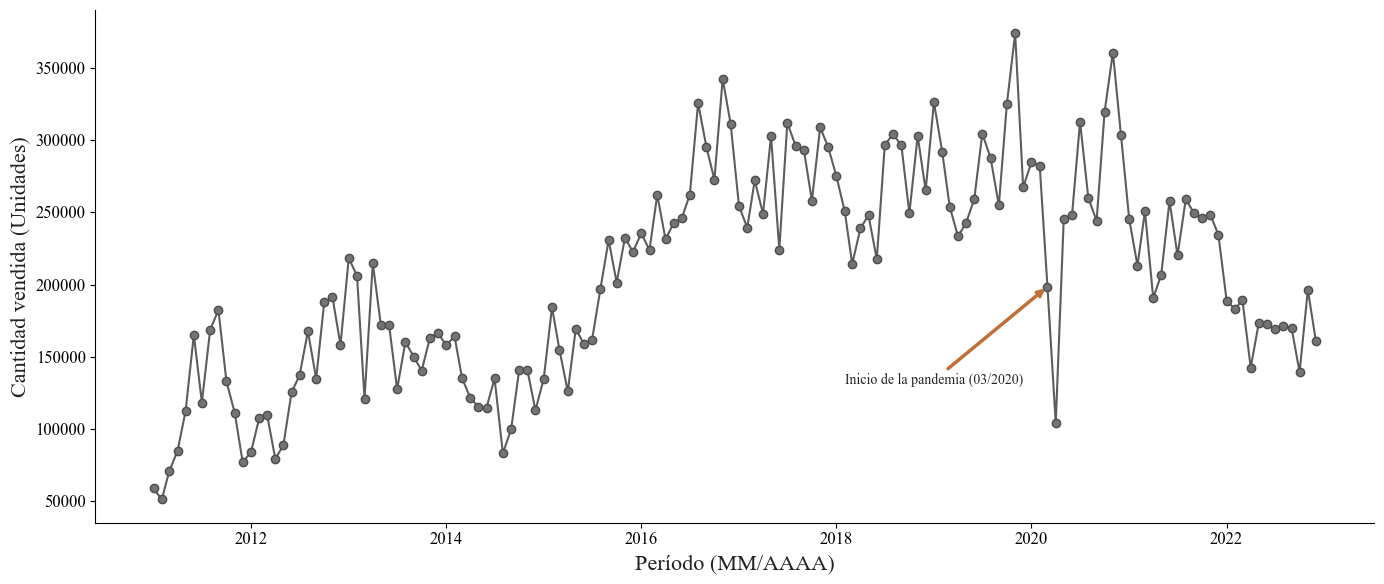

In [12]:
# Asegurar que la columna PERIODO esté en tipo fecha o período mensual
dfVENTAS["PERIODO"] = dfVENTAS["MES_NUM"].map({v: k for k, v in mapa_mes_num.items()})
dfVENTAS["PERIODO"] = dfVENTAS["PERIODO"].astype(str).astype("period[M]")  # ej: 2020-01

# Agrupar por PERIODO (mes/año) y sumar CANTIDAD
ventas_por_mes = dfVENTAS.groupby("PERIODO")["CANTIDAD"].sum().sort_index()

# Convertir a índice de fecha para graficar mejor
ventas_por_mes.index = ventas_por_mes.index.to_timestamp()



# Graficar
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "font.size": 12,
})

plt.figure(figsize=(14, 6))
plt.plot(
    ventas_por_mes.index,
    ventas_por_mes.values,
    marker='o',
    linestyle='-',
    color="#5e5d5d",
    markerfacecolor='#737373',
    markeredgewidth=1,
    markeredgecolor='#4d4d4d'
)

#plt.title("Comportamiento mensual de las ventas", fontsize=18, fontweight='bold', color='#222222')
plt.xlabel("Período (MM/AAAA)", fontsize=16, color='#222222')
plt.ylabel("Cantidad vendida (Unidades)", fontsize=16, color='#222222')

plt.grid(False) #color='#d9d9d9')

ax = plt.gca()  # Obtener el eje actual
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Flecha + texto para marcar marzo de 2020
marzo_2020 = pd.Timestamp('2020-03')
plt.annotate(
    'Inicio de la pandemia (03/2020)',
    xy=(marzo_2020, ventas_por_mes.loc[marzo_2020]),
    xytext=(marzo_2020 - pd.DateOffset(months=25), ventas_por_mes.max() * 0.35),  # Ajusta la altura si queda muy arriba/abajo
    arrowprops=dict(color="#bf6f37", arrowstyle='->', linewidth = 2.5),
    color='#222222',
    fontsize=10,
    ha='left'
)


plt.tight_layout()

# Guardar en EPS
plt.savefig("ventas_mensuales.eps", format='eps')
plt.show()

In [9]:
print(dfVENTAS.columns)

Index(['ID_x', 'IDVENTA', 'EMP', 'TIPO_TRAN', 'NRO_VEN', 'CODI', 'PRE_VEN',
       'CANTIDAD', 'COSTO', 'ESTADO', 'ITEM', 'COD_SAL', 'ASIENTO', 'UCOGS',
       'P', 'NUMERO', 'COSTOREAL', 'STOCKANTE', 'STOCKPOSTE', 'TIPO', 'CHINO',
       'NEGATIVO', 'RAZONNEGA', 'ID_y', 'MES_NUM', 'CLNRO', 'CODI_ORIGINAL',
       'CODI_UNIFICADO', 'PERIODO'],
      dtype='object')


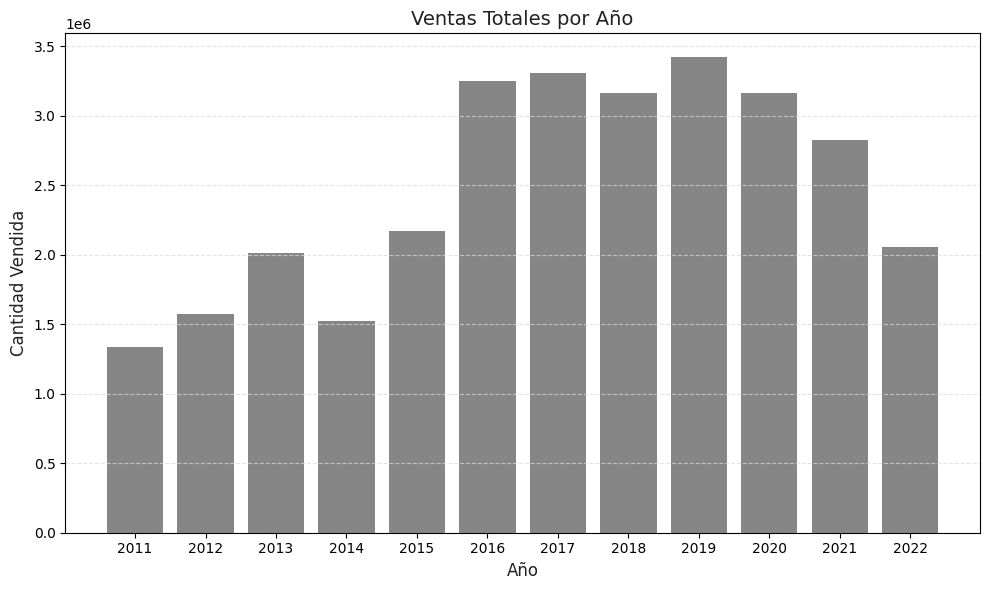

In [10]:
# Extraer año desde 'PERIODO' (que es Period)
dfVENTAS["AÑO"] = dfVENTAS["PERIODO"].dt.year

# Agrupar por año sumando la cantidad
ventas_anuales = dfVENTAS.groupby("AÑO")["CANTIDAD"].sum().sort_index()

# Graficar
plt.figure(figsize=(10, 6))
plt.bar(
    ventas_anuales.index.astype(str), 
    ventas_anuales.values, 
    color="#868686"  # gris oscuro para las barras
)
plt.title("Ventas Totales por Año", fontsize=14, color='#222222')
plt.xlabel("Año", fontsize=12, color='#222222')
plt.ylabel("Cantidad Vendida", fontsize=12, color='#222222')
plt.grid(axis='y', linestyle='--', color='#d9d9d9', alpha=0.7)  # gris claro para grid
plt.tight_layout()
plt.show()

### De anual a mensual por numero de meses

In [11]:
dfVENTAS_grouped = dfVENTAS.groupby(["MES_NUM", "CODI_UNIFICADO"])["CANTIDAD"].sum().reset_index()
dfVENTAS_grouped.rename(columns={"CODI_UNIFICADO": "CODI"}, inplace=True)

mapa_mesnum_a_periodo = {idx + 1: str(periodo) for idx, periodo in enumerate(periodos_ordenados)}
mapa_periodo_a_mesnum = {str(periodo): idx + 1 for idx, periodo in enumerate(periodos_ordenados)}
print("MES_NUM 1 corresponde a:", mapa_mesnum_a_periodo[1])
print("PERIODO '2020-01' corresponde a MES_NUM:", mapa_periodo_a_mesnum["2020-01"])

MES_NUM 1 corresponde a: 2011-01
PERIODO '2020-01' corresponde a MES_NUM: 109


In [12]:
mapa_periodo_a_mesnum["2020-03"]

111

## Fitrado Datos Naturales

### Filtro Todos los artículos

In [13]:
# Base natural
dfVENTAS_N_T_P = dfVENTAS_grouped.copy()
dfVENTAS_N_T_NP = dfVENTAS_N_T_P[dfVENTAS_N_T_P["MES_NUM"] <= mapa_periodo_a_mesnum["2020-02"]]

### Artículos vendidos en ultimos 48 meses

In [14]:
# Último mes en el dataset
ultimo_mes = dfVENTAS_grouped["MES_NUM"].max()

# Últimos 48 meses
meses_48 = sorted(dfVENTAS_grouped["MES_NUM"].unique())[-48:]

# Dividir los 48 meses en 4 bloques de 12 meses (1 año cada uno)
bloques_anuales = [
    meses_48[i*12:(i+1)*12] for i in range(4)
]

# Filtrar solo artículos que aparecen al menos 1 vez en cada bloque
articulos_validos = set(dfVENTAS_N_T_P["CODI"].unique())

for bloque in bloques_anuales:
    articulos_en_bloque = set(
        dfVENTAS_N_T_P[dfVENTAS_N_T_P["MES_NUM"].isin(bloque)]["CODI"].unique()
    )
    articulos_validos &= articulos_en_bloque  # Intersección acumulada

dfVENTAS_N_48_P = dfVENTAS_N_T_P[dfVENTAS_N_T_P["CODI"].isin(articulos_validos)]
dfVENTAS_N_48_NP = dfVENTAS_N_48_P[dfVENTAS_N_48_P["MES_NUM"] <= mapa_periodo_a_mesnum["2020-02"]]

## Filtrado Datos Atípicos

In [15]:
def filtrar_IQR(df, columna="CANTIDAD"):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    return df[(df[columna] >= lim_inf) & (df[columna] <= lim_sup)]

### Filtro todos los articulos

In [16]:
dfVENTAS_F_T_P = filtrar_IQR(dfVENTAS_grouped)
dfVENTAS_F_T_NP = filtrar_IQR(dfVENTAS_grouped[dfVENTAS_grouped["MES_NUM"] <= mapa_periodo_a_mesnum["2020-02"]])

### Articulos 48 meses

In [17]:
# Dividir los últimos 48 meses en 4 bloques de 12 meses
bloques_anuales = [meses_48[i*12:(i+1)*12] for i in range(4)]

articulos_validos_F = set(dfVENTAS_F_T_P["CODI"].unique())

for bloque in bloques_anuales:
    articulos_en_bloque = set(
        dfVENTAS_F_T_P[dfVENTAS_F_T_P["MES_NUM"].isin(bloque)]["CODI"].unique()
    )
    articulos_validos_F &= articulos_en_bloque

dfVENTAS_F_48_P = dfVENTAS_F_T_P[dfVENTAS_F_T_P["CODI"].isin(articulos_validos_F)]
dfVENTAS_F_48_NP = dfVENTAS_F_48_P[dfVENTAS_F_48_P["MES_NUM"] <= mapa_periodo_a_mesnum["2020-02"]]

In [18]:
# Conjunto de artículos válidos en ambas versiones
articulos_comunes = set(dfVENTAS_N_48_P["CODI"].unique()) & set(dfVENTAS_F_48_P["CODI"].unique())

# Filtrar dfVENTAS_N_48_P conservando solo los artículos comunes
dfVENTAS_N_48_P = dfVENTAS_N_48_P[dfVENTAS_N_48_P["CODI"].isin(articulos_comunes)]
dfVENTAS_N_48_NP = dfVENTAS_N_48_P[dfVENTAS_N_48_P["MES_NUM"] <= mapa_periodo_a_mesnum["2020-02"]]

In [19]:
solo_en_F = set(dfVENTAS_F_48_P["CODI"].unique()) - set(dfVENTAS_N_48_P["CODI"].unique())
solo_en_N = set(dfVENTAS_N_48_P["CODI"].unique()) - set(dfVENTAS_F_48_P["CODI"].unique())

print(f"Artículos solo en filtrado (F): {len(solo_en_F)}")
print(f"Artículos solo en natural (N): {len(solo_en_N)}")

Artículos solo en filtrado (F): 0
Artículos solo en natural (N): 0


### Ultimo filtrado, articulos con 4 o mas entradas para que se les pueda aplicar los modelos 

In [20]:
dataframes_ventas = {
    "N_T_P": dfVENTAS_N_T_P,
    "N_T_NP": dfVENTAS_N_T_NP,
    "N_48_P": dfVENTAS_N_48_P,
    "N_48_NP": dfVENTAS_N_48_NP,
    "F_T_P": dfVENTAS_F_T_P,
    "F_T_NP": dfVENTAS_F_T_NP,
    "F_48_P": dfVENTAS_F_48_P,
}

In [21]:
def filtrar_articulos_con_minimo(df, minimo=4):
    conteo = df["CODI"].value_counts()
    codigos_validos = conteo[conteo >= minimo].index
    return df[df["CODI"].isin(codigos_validos)]

for nombre in list(dataframes_ventas.keys()):
    dataframes_ventas[nombre] = filtrar_articulos_con_minimo(dataframes_ventas[nombre])

In [22]:
# Artículos que estaban en datos naturales pero NO en los filtrados
codis_naturales = set(dfVENTAS_N_T_P["CODI"])
codis_filtrados = set(dfVENTAS_F_T_P["CODI"])
codis_perdidos = codis_naturales - codis_filtrados

print(f"Artículos eliminados por el filtrado: {len(codis_perdidos)}")

Artículos eliminados por el filtrado: 317


# Analysis pre experimentos

## Cantidad de articulos disponibles para aplicar modelos

In [18]:
for nombre, df in dataframes_ventas.items():
    print(f"{nombre}: {df['CODI'].nunique()}")

N_T_P: 7656
N_T_NP: 6938
N_48_P: 2660
N_48_NP: 2583
F_T_P: 7339
F_T_NP: 6604
F_48_P: 2660
F_48_NP: 2568


In [19]:
print("Primer PERIODO:", dfVENTA["PERIODO"].min())
print("Último PERIODO:", dfVENTA["PERIODO"].max())
print("Primer MES_NUM:", dfVENTA["MES_NUM"].min())
print("Último MES_NUM:", dfVENTA["MES_NUM"].max())

Primer PERIODO: 2011-01
Último PERIODO: 2022-12
Primer MES_NUM: 1
Último MES_NUM: 144


# Experimentos/Modelado

## Versus de regresion lineal, cuadratica y KNN para todos los dataframes

### Funcion vs1

In [21]:
def vs1(df_input, df_info):

    resultados = []
    df_input = df_input.copy()

    for producto in df_input["CODI"].unique():
        df_producto = df_input[df_input["CODI"] == producto]
        if len(df_producto) < 4:
            continue

        x = df_producto[["MES_NUM"]].values
        y = df_producto["CANTIDAD"].values

        modelo_lineal = LinearRegression().fit(x, y)
        y_pred_lineal = modelo_lineal.predict(x)
        r2_lineal = r2_score(y, y_pred_lineal)
        mae_lineal = mean_absolute_error(y, y_pred_lineal)
        rmse_lineal = np.sqrt(mean_squared_error(y, y_pred_lineal))

        poly = PolynomialFeatures(degree=2)
        x_poly = poly.fit_transform(x)
        modelo_poly = LinearRegression().fit(x_poly, y)
        y_pred_poly = modelo_poly.predict(x_poly)
        r2_poly = r2_score(y, y_pred_poly)
        mae_poly = mean_absolute_error(y, y_pred_poly)
        rmse_poly = np.sqrt(mean_squared_error(y, y_pred_poly))

        if r2_poly > r2_lineal:
            mejor_modelo = "cuadrático"
            r2, mae, rmse = r2_poly, mae_poly, rmse_poly
        else:
            mejor_modelo = "lineal"
            r2, mae, rmse = r2_lineal, mae_lineal, rmse_lineal

        resultados.append({
            "CODI": producto,
            "Modelo_ganador": mejor_modelo,
            "R2_vs1": r2,
            "MAE_vs1": mae,
            "RMSE_vs1": rmse
        })

    df_resultados = pd.DataFrame(resultados)
    df_resultados["CODI"] = df_resultados["CODI"].astype(str)
    df_info["CODI"] = df_info["CODI"].astype(str)
    df_resultados = df_resultados.merge(df_info[["CODI", "DES"]], on="CODI", how="left")
    df_resultados = df_resultados.sort_values(by="R2_vs1", ascending=False).reset_index(drop=True)

    return df_resultados

### Funcion vs2

In [22]:
def vs2(df_input, df_vs1):
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
    import pandas as pd
    import numpy as np

    resultados = []
    df_input = df_input.copy()
    df_vs1 = df_vs1.set_index("CODI")

    for producto in df_input["CODI"].unique():
        df_producto = df_input[df_input["CODI"] == producto]
        if len(df_producto) < 4 or producto not in df_vs1.index:
            continue

        x = df_producto[["MES_NUM"]].values
        y = df_producto["CANTIDAD"].values

        modelo_knn = KNeighborsRegressor(n_neighbors=3)
        modelo_knn.fit(x, y)
        y_pred_knn = modelo_knn.predict(x)
        r2_knn = r2_score(y, y_pred_knn)
        mae_knn = mean_absolute_error(y, y_pred_knn)
        rmse_knn = np.sqrt(mean_squared_error(y, y_pred_knn))

        mejor_vs1 = df_vs1.loc[producto, "Modelo_ganador"]
        r2_vs1 = df_vs1.loc[producto, "R2_vs1"]
        mae_vs1 = df_vs1.loc[producto, "MAE_vs1"]
        rmse_vs1 = df_vs1.loc[producto, "RMSE_vs1"]

        if r2_knn > r2_vs1:
            ganador = "knn"
            r2, mae, rmse = r2_knn, mae_knn, rmse_knn
        else:
            ganador = mejor_vs1
            r2, mae, rmse = r2_vs1, mae_vs1, rmse_vs1

        resultados.append({
            "CODI": producto,
            "Modelo_ganador": ganador,
            "R2_final": r2,
            "MAE_final": mae,
            "RMSE_final": rmse
        })

    df_resultados_vs2 = pd.DataFrame(resultados)
    return df_resultados_vs2

### Filtrar R2 altos

In [23]:
def filtrar_por_r2(df_resultados, umbral=0.6):
    df_filtrado = df_resultados[df_resultados["R2"] >= umbral].copy()
    df_filtrado = df_filtrado.sort_values(by="R2", ascending=False).reset_index(drop=True)
    return df_filtrado

### Aplicar modelos

In [24]:
# Subconjunto deseado
dataframes_filtrados = {
    k: v for k, v in dataframes_ventas.items()
    if k in ["N_48_P", "N_48_NP", "F_48_P", "F_48_NP"]
}

In [25]:
resultados_vs1 = {}
resultados_vs2 = {}

for nombre_df, df in dataframes_filtrados.items():
    print(f"Procesando {nombre_df}...")
    
    # Evaluar vs1 (lineal vs cuadrático)
    df_vs1 = vs1(df, dfINFO)
    resultados_vs1[nombre_df] = df_vs1

    # Evaluar vs2 (ganador vs KNN)
    df_vs2 = vs2(df, df_vs1)
    resultados_vs2[nombre_df] = df_vs2


Procesando N_48_P...
Procesando N_48_NP...
Procesando F_48_P...
Procesando F_48_NP...


In [ ]:
# Aplicar filtro R2 >= 0.6 a todos los resultados de vs1
resultados_vs1_filtrados = {}

for nombre, df in resultados_vs1.items():
    df_filtrado = df.copy()
    df_filtrado.rename(columns={"R2_vs1": "R2"}, inplace=True)
    df_filtrado = filtrar_por_r2(df_filtrado, umbral=0.6)
    resultados_vs1_filtrados[nombre] = df_filtrado

In [ ]:
# Aplicar filtro R2 >= 0.6 a todos los resultados de vs2
resultados_vs2_filtrados = {}

for nombre, df in resultados_vs2.items():
    df_filtrado = df.copy()
    df_filtrado.rename(columns={"R2_final": "R2"}, inplace=True)
    df_filtrado = filtrar_por_r2(df_filtrado, umbral=0.6)
    resultados_vs2_filtrados[nombre] = df_filtrado

# Evaluación

### Resultados Sin filtrar con umbral

In [30]:
for nombre_df, df_vs1 in resultados_vs1.items():
    cantidad_articulos = len(df_vs1)
    print(f"\n{nombre_df} | Artículos = {cantidad_articulos}")

    # Contar cuántos productos ganaron con cada modelo
    conteo_modelos = df_vs1["Modelo_ganador"].value_counts()

    for modelo, cantidad in conteo_modelos.items():
        print(f"{modelo:<11} {cantidad}")


N_48_P | Artículos = 2660
cuadrático  2659
lineal      1

N_48_NP | Artículos = 2583
cuadrático  2576
lineal      7

F_48_P | Artículos = 2660
cuadrático  2636
lineal      24

F_48_NP | Artículos = 2568
cuadrático  2539
lineal      29


In [31]:
for nombre_df, df_vs2 in resultados_vs2.items():
    cantidad_articulos = len(df_vs2)
    print(f"\n{nombre_df} | Artículos = {cantidad_articulos}")

    # Contar cuántos productos ganaron con cada modelo
    conteo_modelos = df_vs2["Modelo_ganador"].value_counts()

    for modelo, cantidad in conteo_modelos.items():
        print(f"{modelo:<11} {cantidad}")



N_48_P | Artículos = 2660
knn         2578
cuadrático  81
lineal      1

N_48_NP | Artículos = 2583
knn         2257
cuadrático  319
lineal      7

F_48_P | Artículos = 2660
knn         2546
cuadrático  90
lineal      24

F_48_NP | Artículos = 2568
knn         2175
cuadrático  364
lineal      29


### Resultados Filtrados por umbral

In [32]:
for nombre, df_filtrado in resultados_vs1_filtrados.items():
    total = len(df_filtrado)
    conteo_modelos = df_filtrado["Modelo_ganador"].value_counts()
    
    print(f"{nombre} | Artículos con R2 >= 0.6 = {total}")
    for modelo, cantidad in conteo_modelos.items():
        print(f"{modelo:11} {cantidad}")

N_48_P | Artículos con R2 >= 0.6 = 13
cuadrático  12
lineal      1
N_48_NP | Artículos con R2 >= 0.6 = 102
cuadrático  95
lineal      7
F_48_P | Artículos con R2 >= 0.6 = 45
lineal      24
cuadrático  21
F_48_NP | Artículos con R2 >= 0.6 = 142
cuadrático  113
lineal      29


In [33]:
for nombre, df_filtrado in resultados_vs2_filtrados.items():
    total = len(df_filtrado)
    conteo_modelos = df_filtrado["Modelo_ganador"].value_counts()
    
    print(f"{nombre} | Artículos con R2 >= 0.6 = {total}")
    for modelo, cantidad in conteo_modelos.items():
        print(f"{modelo:11} {cantidad}")
    print()

N_48_P | Artículos con R2 >= 0.6 = 308
knn         298
cuadrático  9
lineal      1

N_48_NP | Artículos con R2 >= 0.6 = 338
knn         248
cuadrático  83
lineal      7

F_48_P | Artículos con R2 >= 0.6 = 303
knn         270
lineal      24
cuadrático  9

F_48_NP | Artículos con R2 >= 0.6 = 361
knn         240
cuadrático  92
lineal      29



### Tendencia decreciente o creciente de articulos con más recurrencia en ventas

In [46]:
def detectar_tendencia(df_ventas, df_resultados, r2_minimo=0.6):
    resultados = []

    for _, fila in df_resultados.iterrows():
        producto = fila["CODI"]
        r2 = fila.get("R2_final", fila.get("R2_vs1", None))
        if r2 is None or r2 < r2_minimo:
            continue

        df_producto = df_ventas[df_ventas["CODI"] == producto]
        if df_producto["MES_NUM"].nunique() < 4:
            continue

        x = df_producto[["MES_NUM"]].values
        y = df_producto["CANTIDAD"].values

        modelo = LinearRegression().fit(x, y)
        pendiente = modelo.coef_[0]

        if pendiente > 0.1:
            tendencia = "Creciente"
        elif pendiente < -0.1:
            tendencia = "Decreciente"
        else:
            tendencia = "Plana"

        resultados.append({
            "CODI": producto,
            "R2": r2,
            "Tendencia": tendencia
        })

    return pd.DataFrame(resultados)

conjuntos_modelados = ["N_48_P", "N_48_NP", "F_48_P", "F_48_NP"]
tendencias_por_df = {}

for nombre_df in conjuntos_modelados:
    df_ventas = dataframes_ventas[nombre_df]
    df_resultados = resultados_vs2[nombre_df]
    df_tendencia = detectar_tendencia(df_ventas, df_resultados, r2_minimo=0.6)
    tendencias_por_df[nombre_df] = df_tendencia

## Graficar

In [54]:
def graficar_topN(df_ventas, df_resultados, dfINFO, nombre_df, tipo="vs2", top_n=10):
    """
    Grafica top N productos según R2, usando resultados de vs1 o vs2, y usa nombres desde dfINFO.
    
    Parámetros:
    - df_ventas: DataFrame con ventas (columnas: CODI, MES_NUM, CANTIDAD)
    - df_resultados: DataFrame con resultados (vs1 o vs2)
    - dfINFO: DataFrame con info productos (columnas: CODI, DES)
    - nombre_df: nombre para la carpeta de guardado
    - tipo: "vs1" o "vs2" para elegir columnas a usar
    - top_n: cantidad de productos a graficar
    """
    import os
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.neighbors import KNeighborsRegressor
    
    carpeta = os.path.join("Graficos/MENSUAL/Con R2 Filter", nombre_df)
    os.makedirs(carpeta, exist_ok=True)
    
    if tipo == "vs1":
        col_modelo = "Modelo_ganador"
        col_r2 = "R2_vs1"
    elif tipo == "vs2":
        col_modelo = "Modelo_ganador"
        col_r2 = "R2_final"
    else:
        raise ValueError("tipo debe ser 'vs1' o 'vs2'")
    
    # Filtrar top N excluyendo R2 = 1
    df_filtrado = df_resultados[df_resultados[col_r2] < 1].sort_values(by=col_r2, ascending=False).head(top_n)
    
    for _, fila in df_filtrado.iterrows():
        producto = fila["CODI"]
        mejor_modelo = fila[col_modelo]
        r2 = fila[col_r2]
        
        # Buscar nombre en dfINFO
        nombre_articulo = dfINFO.loc[dfINFO["CODI"] == producto, "DES"]
        if not nombre_articulo.empty:
            nombre_articulo = nombre_articulo.values[0]
        else:
            nombre_articulo = "SinNombre"
        
        nombre_limpio = "".join(c for c in str(nombre_articulo) if c.isalnum() or c in (" ", "_")).strip().replace(" ", "_")[:40]
        
        df_producto = df_ventas[df_ventas["CODI"] == producto]
        x = df_producto[["MES_NUM"]].values
        y = df_producto["CANTIDAD"].values
        
        plt.figure(figsize=(8,5))
        plt.scatter(x, y, color="black", label="Datos reales")
        
        if mejor_modelo == "lineal":
            modelo = LinearRegression()
            modelo.fit(x, y)
            y_pred = modelo.predict(x)
            plt.plot(x, y_pred, color="red", label="Regresión lineal")
        
        elif mejor_modelo == "cuadrático":
            poly = PolynomialFeatures(degree=2)
            x_poly = poly.fit_transform(x)
            modelo = LinearRegression()
            modelo.fit(x_poly, y)
            x_plot = np.linspace(x.min(), x.max(), 100).reshape(-1,1)
            x_plot_poly = poly.transform(x_plot)
            y_plot = modelo.predict(x_plot_poly)
            plt.plot(x_plot, y_plot, color="green", label="Regresión cuadrática")
        
        elif mejor_modelo == "knn":
            modelo = KNeighborsRegressor(n_neighbors=3)
            modelo.fit(x, y)
            x_plot = np.linspace(x.min(), x.max(), 100).reshape(-1,1)
            y_plot = modelo.predict(x_plot)
            plt.plot(x_plot, y_plot, color="blue", label="KNN (k=3)")
        
        else:
            plt.title(f"Producto {producto} - {nombre_articulo}\nModelo: {mejor_modelo} (no graficado)")
        
        if mejor_modelo in ["lineal", "cuadrático", "knn"]:
            plt.title(f"Producto {producto} - {nombre_articulo}\nModelo: {mejor_modelo}")
        
        plt.xlabel("MES_NUM")
        plt.ylabel("Cantidad vendida")
        plt.legend()
        plt.grid(True)
        
        plt.text(0.02, 0.95, f"$R^2$ = {r2:.3f}",
                 transform=plt.gca().transAxes,
                 fontsize=10,
                 verticalalignment="top",
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray"))
        
        ruta_archivo = os.path.join(carpeta, f"{nombre_limpio}_CODI{producto}_{mejor_modelo}.png")
        plt.tight_layout()
        plt.savefig(ruta_archivo)
        plt.close()


In [47]:
top_n = 100
conjuntos_modelados = ["N_48_P", "N_48_NP", "F_48_P", "F_48_NP"]

for nombre_df in conjuntos_modelados:
    df_ventas = dataframes_ventas[nombre_df]
    print(f"Graficando top {top_n} de {nombre_df} con resultados vs2...")
    graficar_topN(
        df_ventas=df_ventas,
        df_resultados=resultados_vs2[nombre_df],
        dfINFO=dfINFO,
        nombre_df=nombre_df,
        tipo="vs2",
        top_n=top_n
    )


Graficando top 100 de N_48_P con resultados vs2...
Graficando top 100 de N_48_NP con resultados vs2...
Graficando top 100 de F_48_P con resultados vs2...
Graficando top 100 de F_48_NP con resultados vs2...


In [ ]:
colores = {
    'N': "#0400ff",        
    'F': "#2F44FF",        
    'N_R2': "#ff0011",     
    'F_R2': "#ff2336"      
}

pares = [
    ("N_48_P", "F_48_P"),
    ("N_48_NP", "F_48_NP")
]

def contar_modelos(df_resultados, columna_modelo):
    return df_resultados[columna_modelo].value_counts().to_dict()

def graficar_comparacion(df1, df2, nombre1, nombre2, tipo='CL'):
    modelo_col = "Modelo_ganador"

    conteo1 = contar_modelos(df1, modelo_col)
    conteo2 = contar_modelos(df2, modelo_col)

    df1_f = resultados_vs1_filtrados[nombre1] if tipo == 'CL' else resultados_vs2_filtrados[nombre1]
    df2_f = resultados_vs1_filtrados[nombre2] if tipo == 'CL' else resultados_vs2_filtrados[nombre2]

    conteo1_f = contar_modelos(df1_f, modelo_col)
    conteo2_f = contar_modelos(df2_f, modelo_col)

    modelos = sorted(list(set(conteo1) | set(conteo2) | set(conteo1_f) | set(conteo2_f)))

    data = []
    for modelo in modelos:
        data.extend([
            {'Modelo': modelo, 'Grupo': f'{nombre1}', 'Cantidad': conteo1.get(modelo, 0), 'Color': colores['N']},
            {'Modelo': modelo, 'Grupo': f'{nombre2}', 'Cantidad': conteo2.get(modelo, 0), 'Color': colores['F']},
            {'Modelo': modelo, 'Grupo': f'{nombre1}_R2', 'Cantidad': conteo1_f.get(modelo, 0), 'Color': colores['N_R2']},
            {'Modelo': modelo, 'Grupo': f'{nombre2}_R2', 'Cantidad': conteo2_f.get(modelo, 0), 'Color': colores['F_R2']}
        ])

    df_plot = pd.DataFrame(data)
    orden_grupos = [f'{nombre1}', f'{nombre2}', f'{nombre1}_R2', f'{nombre2}_R2']

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_plot, x='Modelo', y='Cantidad', hue='Grupo',
                palette={fila['Grupo']: fila['Color'] for fila in data},
                hue_order=orden_grupos,
                edgecolor='black')

    plt.title(f'Comparación de Modelos ({tipo}) - {nombre1} vs {nombre2}')
    plt.ylabel('Cantidad de Artículos')
    plt.xlabel('Modelos')
    plt.legend(title='Grupo')
    plt.tight_layout()
    plt.grid(True)

    ruta_guardado = "Graficos/MENSUAL/Barras"
    os.makedirs(ruta_guardado, exist_ok=True)
    
    nombre_archivo = f"{nombre1}_vs_{nombre2}_{tipo}.png"
    plt.savefig(os.path.join(ruta_guardado, nombre_archivo), dpi=300, bbox_inches='tight')
    plt.show()

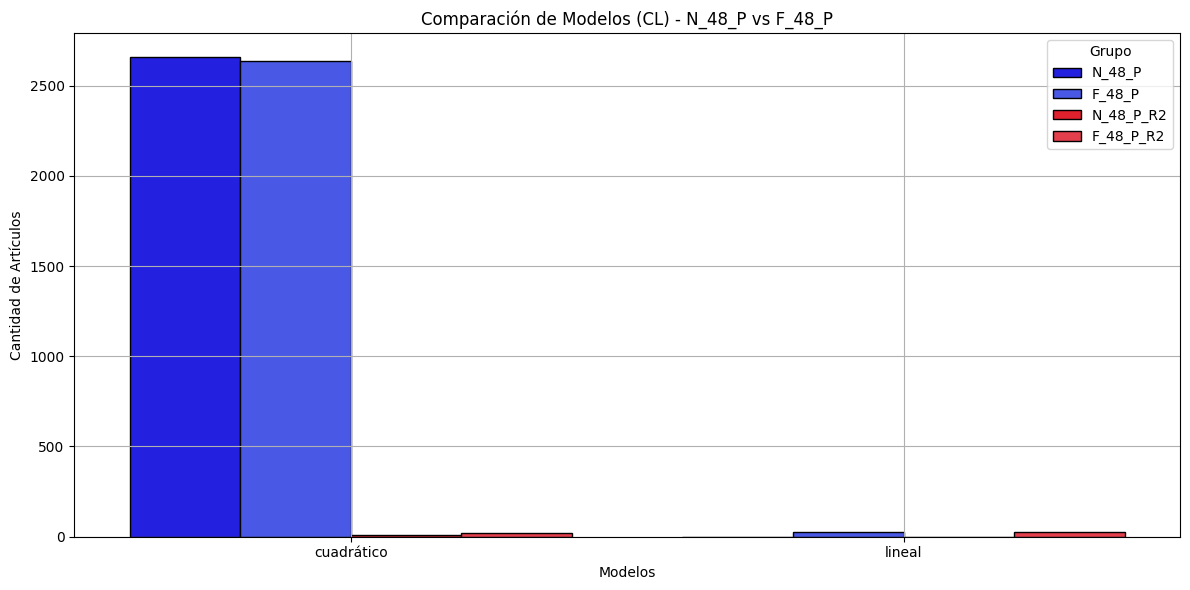

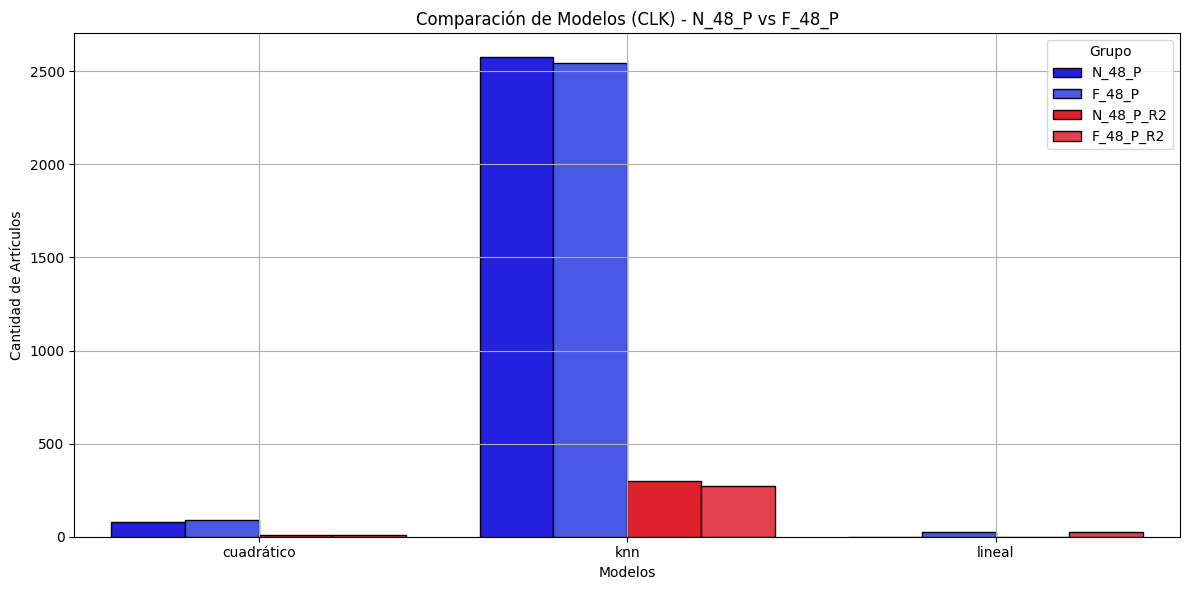

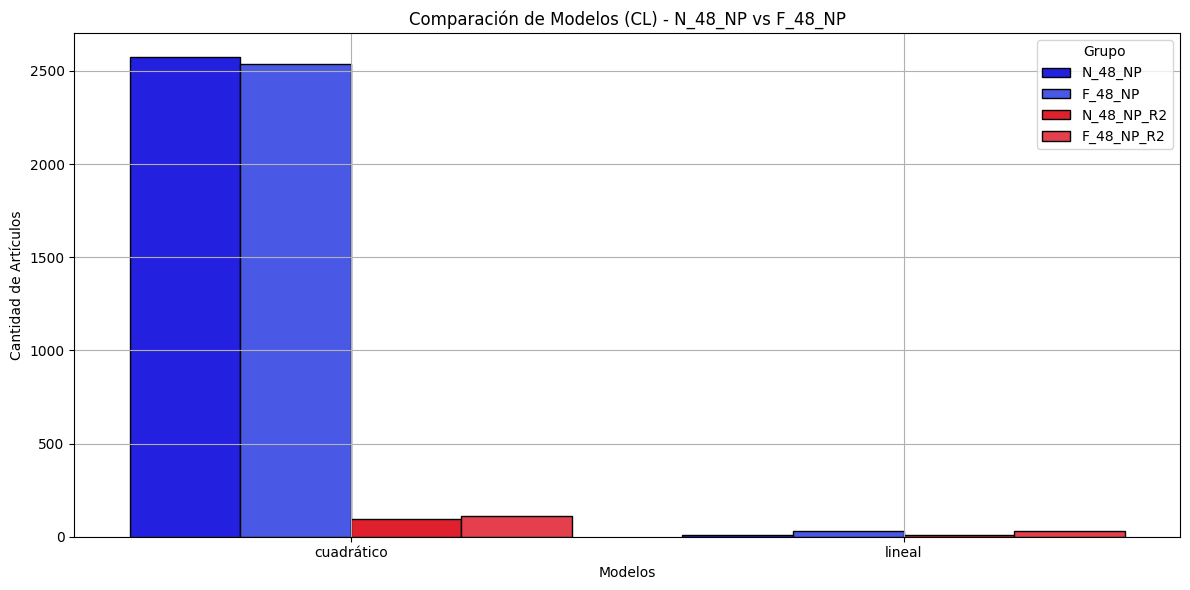

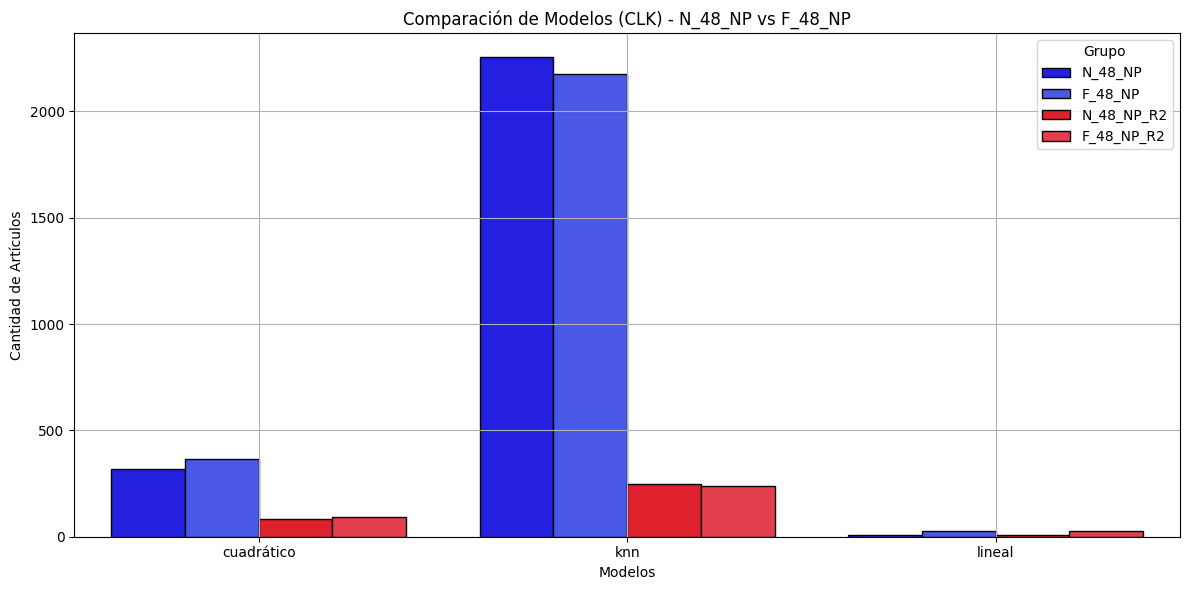

In [ ]:
# Ejecutar para todos los pares
for nombre1, nombre2 in pares:
    graficar_comparacion(resultados_vs1[nombre1], resultados_vs1[nombre2], nombre1, nombre2, tipo='CL')
    graficar_comparacion(resultados_vs2[nombre1], resultados_vs2[nombre2], nombre1, nombre2, tipo='CLK')

In [52]:
#Graficar las tendencias crecientes y decrecientes de articulos con más recurrencia

def graficar_top4_tendencia_por_modelo(df_ventas, df_resultados, df_tendencias, dfINFO, nombre_df, tipo="vs2", r2_minimo=0.6):
    import pandas as pd

    if tipo == "vs2":
        col_modelo = "Modelo_ganador"
        col_r2 = "R2_final"
    elif tipo == "vs1":
        col_modelo = "Mejor_Modelo_vs1"
        col_r2 = "R2_vs1"
    else:
        raise ValueError("tipo debe ser 'vs1' o 'vs2'")

    # Merge resultados + tendencias + filtro R2
    df_merge = df_resultados.merge(df_tendencias, on="CODI")
    df_filtrado = df_merge[df_merge[col_r2] >= r2_minimo]

    modelos_unicos = df_filtrado[col_modelo].unique()

    for modelo in modelos_unicos:
        df_modelo = df_filtrado[df_filtrado[col_modelo] == modelo].copy()

        for tendencia_actual in ["Creciente", "Decreciente"]:
            df_tendencia = df_modelo[df_modelo["Tendencia"] == tendencia_actual].copy()

            # Contar meses distintos con venta por producto
            conteos = df_ventas[df_ventas["CODI"].isin(df_tendencia["CODI"])]
            meses_por_producto = conteos.groupby("CODI")["MES_NUM"].nunique().reset_index()
            meses_por_producto.rename(columns={"MES_NUM": "MesesVendidos"}, inplace=True)

            df_tendencia = df_tendencia.merge(meses_por_producto, on="CODI")
            df_top4 = df_tendencia.sort_values("MesesVendidos", ascending=False).head(4)

            if len(df_top4) == 0:
                print(f"⚠️ Sin artículos {tendencia_actual} con modelo {modelo} y R2 >= {r2_minimo}")
                continue

            print(f"📊 Graficando top 4 {tendencia_actual} ({modelo}) de {nombre_df}...")

            graficar_topN(
                df_ventas=df_ventas,
                df_resultados=df_top4,
                dfINFO=dfINFO,
                nombre_df=f"{nombre_df}_TOP4_{modelo}_{tendencia_actual}",
                tipo=tipo,
                top_n=4
            )

In [55]:
# Ejecutar el gráfico de tendencias solo en los conjuntos que tienen resultados
conjuntos_modelados = ["N_48_P", "N_48_NP", "F_48_P", "F_48_NP"]

for nombre_df in conjuntos_modelados:
    df_ventas = dataframes_ventas[nombre_df]
    df_resultados = resultados_vs2[nombre_df]
    df_tendencias = tendencias_por_df[nombre_df]

    graficar_top4_tendencia_por_modelo(
        df_ventas=df_ventas,
        df_resultados=df_resultados,
        df_tendencias=df_tendencias,
        dfINFO=dfINFO,
        nombre_df=nombre_df,
        tipo="vs2",
        r2_minimo=0.6
    )


📊 Graficando top 4 Creciente (knn) de N_48_P...
📊 Graficando top 4 Decreciente (knn) de N_48_P...
📊 Graficando top 4 Creciente (cuadrático) de N_48_P...
📊 Graficando top 4 Decreciente (cuadrático) de N_48_P...
⚠️ Sin artículos Creciente con modelo lineal y R2 >= 0.6
⚠️ Sin artículos Decreciente con modelo lineal y R2 >= 0.6
📊 Graficando top 4 Creciente (knn) de N_48_NP...
📊 Graficando top 4 Decreciente (knn) de N_48_NP...
📊 Graficando top 4 Creciente (cuadrático) de N_48_NP...
📊 Graficando top 4 Decreciente (cuadrático) de N_48_NP...
⚠️ Sin artículos Creciente con modelo lineal y R2 >= 0.6
📊 Graficando top 4 Decreciente (lineal) de N_48_NP...
📊 Graficando top 4 Creciente (knn) de F_48_P...
📊 Graficando top 4 Decreciente (knn) de F_48_P...
⚠️ Sin artículos Creciente con modelo lineal y R2 >= 0.6
⚠️ Sin artículos Decreciente con modelo lineal y R2 >= 0.6
📊 Graficando top 4 Creciente (cuadrático) de F_48_P...
📊 Graficando top 4 Decreciente (cuadrático) de F_48_P...
📊 Graficando top 4 Crec